# Imports and setups

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
from PIL import Image
from IPython.display import clear_output
import time

%matplotlib inline

In [2]:
set_seed = torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = 4

device

device(type='cuda')

In [ ]:
np.arange()

In [9]:
def live_plot(title, xlabel, ylabel, *data, figsize=(7,5)):
        '''
        A function for live plotting. Parameters:
        Title
        xlabel
        ylabel
        *data: [(xlegend, xarray), (y0legend, y0array)...]
        '''
        for i in range(len(data)):
                data[i] = (data[i][0], data[i][1].astype('float64'))

        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.grid(True)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        for label, array in data[1:]:
                plt.plot(data[0][1], array, label=label if len(data) > 2 else "")
        plt.show()

# Data generator

In [3]:
train_set = torchvision.datasets.FashionMNIST(root = "/home/pachy/Desktop/ACSAI/acsai/Deep Learning/Class/Exercises/mlp_fromscratch/FashionMNIST",
                                                  download = True,
                                                  train=True,
                                                  transform=torchvision.transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = "/home/pachy/Desktop/ACSAI/acsai/Deep Learning/Class/Exercises/mlp_fromscratch/FashionMNIST",
                                                  download = True,
                                                  train=False,
                                                  transform=torchvision.transforms.ToTensor())

In [4]:
train_set, val_set = torch.utils.data.random_split(train_set, [0.7, 0.3])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=workers)

# Model


In [5]:
class MLP(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden_units, num_hidden_layers = 1):
        super().__init__()
        hiddens = [f for x in range(num_hidden_layers - 1) for f in (torch.nn.Linear(num_hidden_units, num_hidden_units), torch.nn.ReLU())]
        self.model = torch.nn.Sequential(torch.nn.Flatten(),
                                        torch.nn.Linear(in_features=num_inputs, 
                                                         out_features=num_hidden_units),
                                        torch.nn.ReLU(),
                                        *hiddens,
                                        torch.nn.Linear(in_features=num_hidden_units,
                                                        out_features=num_outputs))
        
    def forward(self, x):
        return self.model(x)

# Trainer

In [6]:
class Trainer:
    def __init__(self, model, loss, optimizer, acc_metric, batchsize = 32, epochs = 5):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.batchsize = batchsize
        self.accuracy = acc_metric

    def live_plot(self, train_loss, val_loss, val_accuracy, figsize=(7,5), title='Model performance in training'):
        '''
        It plots only the average loss and validation per epoch.
        '''
        train_loss = train_loss.astype('float64')
        val_loss = val_loss.astype('float64')
        #val_accuracy = val_accuracy.astype('float64')
        x = np.arange(train_loss.shape[0])

        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.plot(x, train_loss, label = "Training loss")
        plt.plot(x, val_loss, label = "Validation loss")
        plt.plot(x, val_accuracy, label = "Validation accuracy")
        plt.legend()
        plt.show()
        
    def fit_model(self, train_loader, val_loader):
        '''
        A function that optimizes the model and plots the results.
        '''
        
        train_loss = np.array([])
        val_loss = np.array([])
        val_accuracy = np.array([])

        for i in range(self.epochs):
            # Total loss and accuracies are needed for plotting
            training_total_loss = 0
            validation_total_loss = 0
            validation_total_accuracy = 0

            for j, data in enumerate(train_loader):  
                x, y = data
                x = x.to(device)
                y = y.to(device)

                # Loss computation
                self.model.train()
                self.optimizer.zero_grad()

                y_hat = self.model(x)
                loss = self.loss(y_hat, y)

                # Optimization
                loss.backward()
                self.optimizer.step()

                # Tracking total loss
                training_total_loss += loss.cpu().detach().numpy()

            train_loss = np.append(train_loss, training_total_loss/(j+1))   # this is needed for plotting
            
            # Validation
            self.model.eval()
            with torch.no_grad():
                for j, data in enumerate(train_loader):  
                    x, y = data
                    x = x.to(device)
                    y = y.to(device)

                    y_hat = self.model(x)
                    validation_total_loss += self.loss(y_hat, y).cpu().detach().numpy()
                    validation_total_accuracy += self.accuracy(y_hat, y).cpu().detach().numpy()
                
                val_loss = np.append(val_loss, validation_total_loss/(j+1))   # this is needed for plotting
                val_accuracy = np.append(val_accuracy, validation_total_accuracy/(j+1))

            # Updating the training plot
            self.live_plot(train_loss, val_loss, val_accuracy)

    def test_model(self, test_loader):
        '''
        A function that tests the model and plots the results.
        '''
        
        test_loss = np.array([])
        test_accuracy = np.array([])

        for i, data in enumerate(test_loader):
            # Data loading  
            x, y = data
            x = x.to(device)
            y = y.to(device)

            # Loss and accuracy computation
            self.model.eval()

            with torch.no_grad():
                y_hat = self.model(x)
                loss = self.loss(y_hat, y)
                accuracy = self.accuracy(y_hat, y)
                test_loss = np.append(test_loss, loss.cpu().detach().numpy())   # this is needed for plotting
                test_accuracy = np.append(test_accuracy, accuracy.cpu().detach().numpy())

        return np.mean(test_loss), np.mean(test_accuracy)        

# Training tests


## Normal training

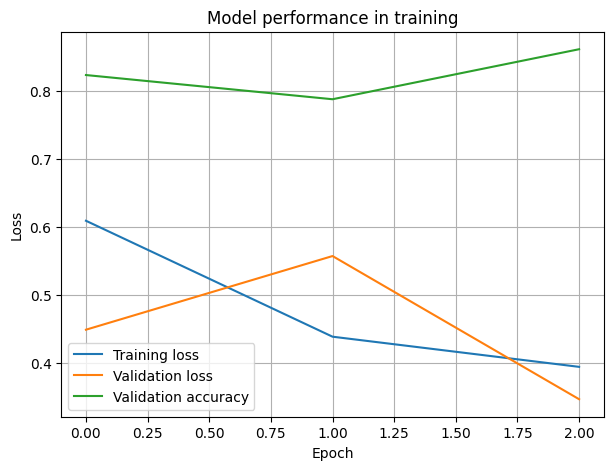

In [7]:
# Note how model AND ACCURACY need both to be on GPU

model = MLP(num_inputs=28*28,
            num_hidden_units=256,
            num_hidden_layers=1,
            num_outputs=10).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.3)
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=10).to(device)
trainer = Trainer(model, loss, optimizer, accuracy, epochs=3)

trainer.fit_model(train_loader, val_loader)

## Parametrized on number of hidden units

In [111]:
def live_plot_test_hiddens(num_hiddens, accuracy, figsize=(7,5), title='Accuracy vs n. of hidden units per layer'):
        '''
        It plots the accuracy on the number of hidden units, live.
        '''
        num_hiddens = num_hiddens.astype('float64')
        accuracy = accuracy.astype('float64')

        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Hidden units per layer')
        plt.ylabel('Mean accuracy over all epochs')

        plt.plot(num_hiddens, accuracy)
        plt.show()

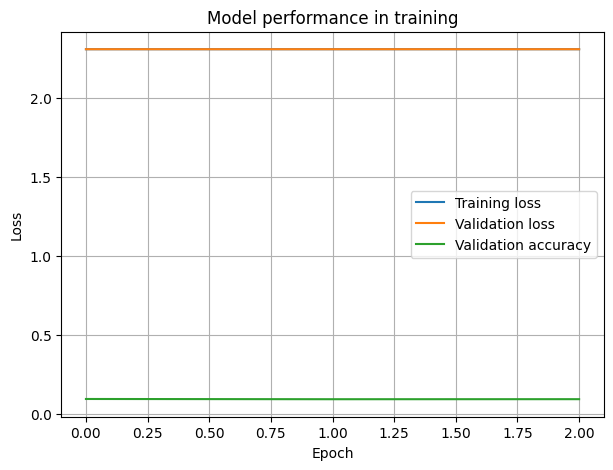

In [131]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.3)
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=10).to(device)

hidden_units = np.array([])
accuracy_record_units = np.array([])

for i in range(11):
    print(f"Model with {2**i} hidden units per hidden layer")
    model = MLP(num_inputs=28*28,
            num_hidden_units=2**i,
            num_hidden_layers=1,
            num_outputs=10).to(device)
    trainer = Trainer(model, loss, optimizer, accuracy, epochs=3)

    trainer.fit_model(train_loader, val_loader)
    mean_loss, mean_accuracy = trainer.test_model(test_loader)

    hidden_units = np.append(hidden_units, 2**i)
    accuracy_record_units = np.append(accuracy_record_units, mean_accuracy)

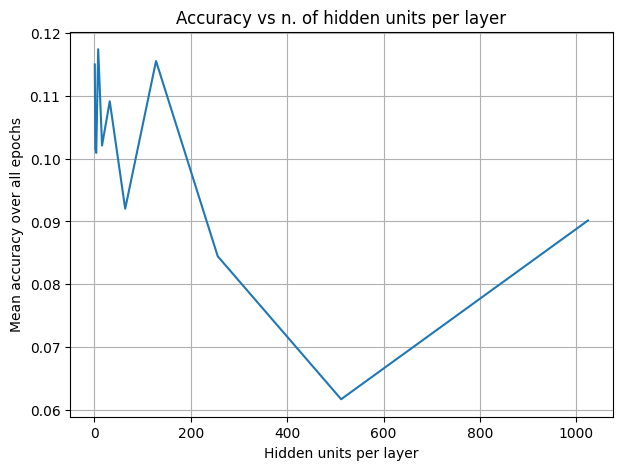

In [132]:
# Plotting the whole accuracy vs params graph

live_plot_test_hiddens(num_hiddens=hidden_units, accuracy=accuracy_record)

## Parametrized on number of hidden layers

In [136]:
def live_plot_test_layers(num_hiddens, accuracy, figsize=(7,5), title='Accuracy vs n. of hidden layers'):
        '''
        It plots the accuracy on the number of hidden layers, live.
        '''
        num_hiddens = num_hiddens.astype('float64')
        accuracy = accuracy.astype('float64')

        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Hidden layers')
        plt.ylabel('Mean accuracy over all epochs')

        plt.plot(num_hiddens, accuracy)
        plt.show()

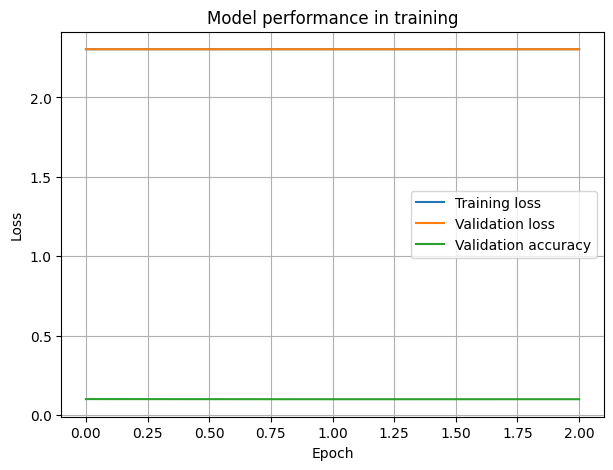

In [152]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.3)
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=10).to(device)

hidden_layers = np.array([])
accuracy_record_layers = np.array([])

for i in range(1, 6):
    print(f"Model with {i} hidden layers")
    model = MLP(num_inputs=28*28,
            num_hidden_units=256,
            num_hidden_layers=i,
            num_outputs=10).to(device)
    trainer = Trainer(model, loss, optimizer, accuracy, epochs=3)

    trainer.fit_model(train_loader, val_loader)
    mean_loss, mean_accuracy = trainer.test_model(test_loader)

    hidden_layers = np.append(hidden_units, i)
    accuracy_record_layers = np.append(accuracy_record_layers, mean_accuracy)

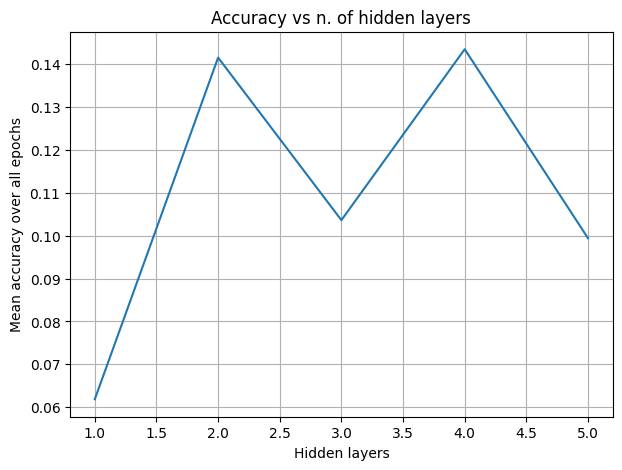

In [155]:
# Plotting the whole accuracy vs params graph

live_plot_test_layers(num_hiddens=np.arange(1, 6), accuracy=accuracy_record_layers)

## Parametrized on learning rate

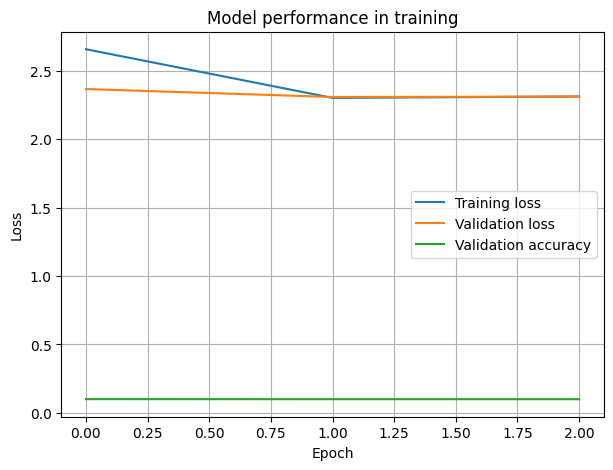

In [10]:
model = model = MLP(num_inputs=28*28,
            num_hidden_units=256,
            num_hidden_layers=1,
            num_outputs=10).to(device)
loss = torch.nn.CrossEntropyLoss()
accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=10).to(device)

lr = np.array([])
accuracy_record_lr = np.array([])

for i in range(-4, 1):
    print(f"Model with lr={10**i}")
    optimizer = torch.optim.SGD(params=model.parameters(), lr=10**i)
    trainer = Trainer(model, loss, optimizer, accuracy, epochs=3)

    trainer.fit_model(train_loader, val_loader)
    mean_loss, mean_accuracy = trainer.test_model(test_loader)

    lr = np.append(lr, i)
    accuracy_record_lr = np.append(accuracy_record_lr, mean_accuracy)

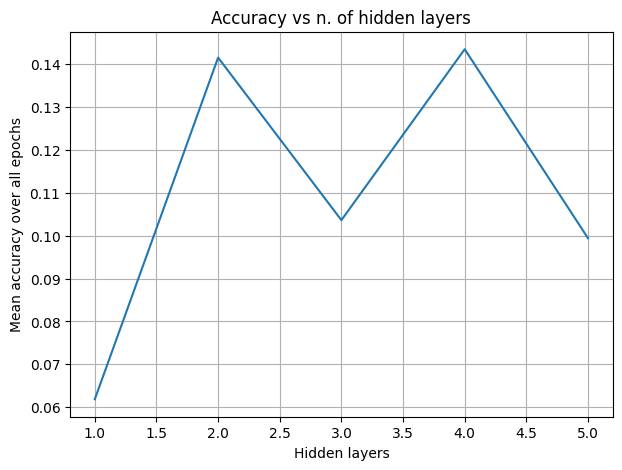

In [ ]:
# Plotting the whole accuracy vs params graph

live_plot("Accuracy change with lr",
          "Learning rate",
          "Accuracy",
          ("", lr), ("Accuracy for that learning rate", accuracy_record_lr))